<a href="https://colab.research.google.com/github/nidhaloff/LR_finder_example/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using TensorFlow backend.


(1000, 1) (1000, 1)
torch.Size([900, 1]) torch.Size([900, 1])


/usr/local/lib/python3.6/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()


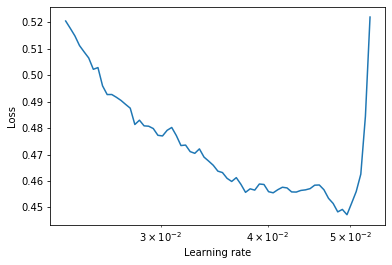

Stopping early, the loss has diverged

Learning rate search finished. See the graph with {finder_name}.plot()


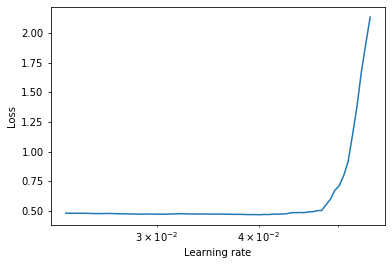

Epoch: 0 => average training loss= 0.4718768894672394 average test losses= 0.4597247540950775 and accuracy=0.051277059279410064
Epoch: 1 => average training loss= 0.4594505826632182 average test losses= 0.4682385176420212 and accuracy=0.033707411501350315
Epoch: 2 => average training loss= 0.45531535148620605 average test losses= 0.46448005239168805 and accuracy=0.04146367524167579
Epoch: 3 => average training loss= 0.45288969990279937 average test losses= 0.4638630077242851 and accuracy=0.04273705297986152
Epoch: 4 => average training loss= 0.45180031127399867 average test losses= 0.46440887451171875 and accuracy=0.041610560885245396
Epoch: 5 => average training loss= 0.44952211611800724 average test losses= 0.4612597127755483 and accuracy=0.0481094173917471
Epoch: 6 => average training loss= 0.4480428165859646 average test losses= 0.4608655571937561 and accuracy=0.0489228241493168
Epoch: 7 => average training loss= 0.4462575664122899 average test losses= 0.45864351093769073 and accur

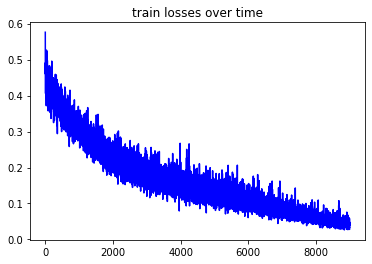

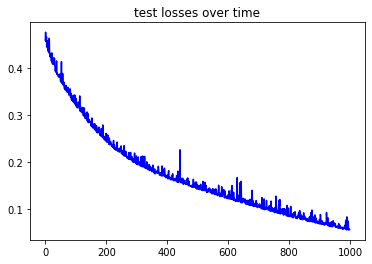

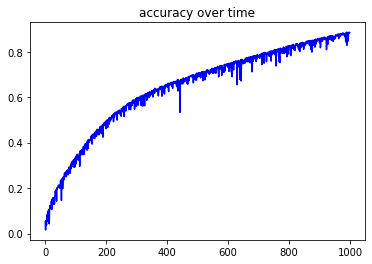

final train loss value =  0.029359040781855583
final test loss value =  0.05632879212498665
final accuracy of the model =>  0.8837556285144132


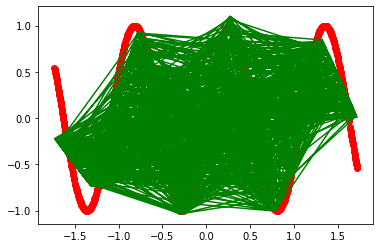

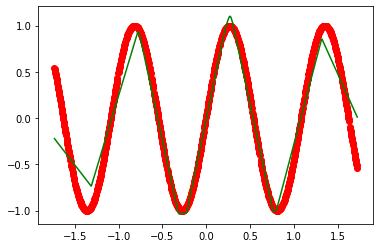

In [1]:
import keras
from keras import backend as K
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
!pip install torch_lr_finder
from torch_lr_finder import LRFinder

%matplotlib inline

# create random dataset for regression

# dataset = make_regression(n_samples=100, n_features=1, noise=3, random_state=0)
# X, y = dataset
X = np.linspace(-10, 10, 1000).reshape(-1, 1)
y = np.sin(X) #+ 0.2* np.random.rand(X.shape)
X.shape, y.shape

# implementation using pytorch

# transform data to Tensors and split testset and validation set
y = y.reshape(-1, 1)
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)
X_train_torch = torch.from_numpy(X_train.astype(np.float32))
y_train_torch = torch.from_numpy(y_train.astype(np.float32))
X_test_torch = torch.from_numpy(X_test.astype(np.float32))
y_test_torch = torch.from_numpy(y_test.astype(np.float32))

# normalize data
X_train_torch = (X_train_torch - torch.mean(X_train_torch)) / torch.std(X_train_torch)
X_test_torch = (X_test_torch - torch.mean(X_test_torch)) / torch.std(X_test_torch)

print(X_train_torch.shape, y_train_torch.shape)

X = torch.from_numpy(X.astype(np.float32))
y = torch.from_numpy(y.astype(np.float32))


# create a TensorDataset from the actual dataset
coarse_trainset = TensorDataset(X_train_torch, y_train_torch)
coarse_testset = TensorDataset(X_test_torch, y_test_torch)
trainset = TensorDataset(X, y)

# create the loader of the dataset
coarse_train_loader = DataLoader(coarse_trainset, batch_size=100, shuffle=True)
coarse_test_loader = DataLoader(coarse_testset, batch_size=100, shuffle=False)
loader = DataLoader(trainset, batch_size=len(y), shuffle=True)

# definition of the Coarse Model
class CoarseModel(nn.Module):
    """main neural network to learn input/position relationship"""
    def __init__(self, n_features, n_hidden, n_out):
        super().__init__()
        self.fc1 = nn.Linear(n_features, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_out)
        
    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = self.fc2(out)
        return out
    

coarse_model = CoarseModel(X.shape[1], 100, 1)


# training function => will perform a single training step given a batch
def training_func(model, criterion, optimizer):
    def train_step(sample, target):
        model.train()
        optimizer.zero_grad()
        out = model(sample)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        return loss.item()
    return train_step


# fit function will train the given Model over defined epochs 
def fit(epochs, model, lr, train_loader, test_loader):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    lr_finder = LRFinder(model, optimizer, criterion)
    lr_finder.range_test(train_loader, end_lr=10, num_iter=500, step_mode="exp")
    lr_finder.plot()
    lr_finder.reset()
    lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=10, num_iter=500, step_mode="exp")
    lr_finder.plot(skip_end=1)
    lr_finder.reset()
    
    train_losses, test_losses, accuracy_list = ([] for _ in range(3))
    train = training_func(model=model, criterion=criterion, optimizer=optimizer)
    for e in range(epochs):
        for x, y in train_loader:
            loss_val = train(x, y)
            train_losses.append(loss_val)
            
        else:
            with torch.no_grad():
                model.eval()
                for x_test, y_test in test_loader:
                    pred = model(x_test)
                    loss = criterion(pred, y_test)
                    test_losses.append(loss.item())
                    accuracy = r2_score(y_test.numpy(), pred.numpy())
                    accuracy_list.append(accuracy)
                    
        print(f"Epoch: {e} => average training loss= {sum(train_losses)/ len(train_losses)} average test losses= {sum(test_losses)/ len(test_losses)} and accuracy={sum(accuracy_list)/ len(accuracy_list)}")
        
    return train_losses, test_losses, accuracy_list
                    

# plot the results of the training and testing loss values over the iterations
def plot_results(train_losses, test_losses, accs):
    plt.plot(train_losses, color="b")
    plt.title("train losses over time")
    plt.show()
    plt.plot(test_losses, color= "b")
    plt.title("test losses over time")
    plt.show()
    plt.plot(accs, color= "b")
    plt.title("accuracy over time")
    plt.show()
    

# train the Coarse Model
train_losses, test_losses, accs = fit(epochs=1000, 
                                      model=coarse_model, 
                                      lr=0.02, 
                                      train_loader=coarse_train_loader, 
                                      test_loader=coarse_test_loader)

plot_results(train_losses, test_losses, accs)
print("final train loss value = ", train_losses[-1])
print("final test loss value = ", test_losses[-1])
print("final accuracy of the model => ", accs[-1])




with torch.no_grad():
    coarse_model.eval()
    criterion = nn.MSELoss()
    coarse_preds = coarse_model(X_train_torch)
    
    coarse_loss = criterion(coarse_preds, y_train_torch)

        

plt.scatter(X_train_torch.detach().numpy(), y_train_torch.detach().numpy(), c="r", marker="o")
plt.plot(X_train_torch.detach().numpy(), coarse_preds.detach().numpy(), color="g")
plt.show()


X_train_torch_sorted, idx = torch.sort(X_train_torch, 0)
coarse_pred_sorted = coarse_model(X_train_torch_sorted)

plt.scatter(X_train_torch.detach().numpy(), y_train_torch.detach().numpy(), c="r", marker="o")
plt.plot(X_train_torch_sorted.detach().numpy(), coarse_preds[idx.numpy().flatten()].detach().numpy(), color="g")
plt.show()

# plt.scatter(X_train_torch.detach().numpy(), y_train_torch.detach().numpy(), c="r", marker="o")
# plt.plot(X_train_torch_sorted.detach().numpy(), coarse_pred_sorted.detach().numpy(), color="g")
# plt.show()


